In [190]:
"""
2D Navier-Stokes Equation (vorticity-streamfunction formulation)
    Spatial: CDS and Arakawa scheme
    Temporal: RK3
"""
import sys
import numpy as np
import scipy
from numba import njit, jit, float64, int64
import pyfftw

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib
import scipy.sparse
import numpy.linalg
from tqdm.notebook import tqdm
np.set_printoptions(threshold=sys.maxsize, linewidth=np.inf)

%matplotlib inline

matplotlib.rcParams['figure.dpi'] = 1200
matplotlib.rcParams['savefig.dpi'] = 1200
matplotlib.rcParams['contour.negative_linestyle'] = 'solid'


In [191]:
@njit(float64(float64[:, :]))
def rms(a):
    return np.sqrt(np.mean(a**2))


In [192]:
def BoundaryConditionDir(w, s, dX, dY):
    s[0, :] = 0
    s[-1, :] = 0
    s[:, 0] = 0
    s[:, -1] = 0

    w[0, :] = (-4*s[1, :] + 0.5*s[2, :])/dX**2
    w[-1, :] = (-4*s[-2, :] + 0.5*s[-3, :])/dX**2

    w[:, 0] = (-4*s[:, 1] + 0.5*s[:, 2])/dY**2
    # Modified from -3 to +3 to match the verification exercise
    w[:, -1] = (-4*s[:, -2] + 0.5*s[:, -3])/dY**2 + 3/dY


In [193]:
def BoundaryConditionPer(w):
    w[1:-1,-1] = w[1:-1,1]
    w[-1,1:-1] = w[1,1:-1]
    w[-1,-1] =   w[1,1]
    w[1:,0] =    w[1:,-2]
    w[0,1:] =    w[-2,1:]
    w[0,0] =     w[-2,-2]

In [194]:
def rhs(omega, psi, dX, dY, Re): # checked
    result = psi*0
    viscousContribution = 1/Re*(
        (omega[0:-2, 1:-1]+omega[2:, 1:-1] - 2*omega[1:-1, 1:-1])/dX**2 +
        (omega[1:-1, 0:-2]+omega[1:-1, 2:] - 2*omega[1:-1, 1:-1])/dY**2
    )

    J1 = (
        (omega[2:, 1:-1]-omega[0:-2, 1:-1])*(psi[1:-1, 2:]-psi[1:-1, 0:-2]) -
        (omega[1:-1, 2:]-omega[1:-1, 0:-2])*(psi[2:, 1:-1]-psi[0:-2, 1:-1])
    )

    J2 = (
        omega[2:, 1:-1]*(psi[2:, 2:] - psi[2:, :-2]) -
        omega[:-2, 1:-1]*(psi[:-2, 2:] - psi[:-2, :-2]) -
        omega[1:-1, 2:]*(psi[2:, 2:] - psi[:-2, 2:]) +
        omega[1:-1, :-2]*(psi[2:, :-2]-psi[:-2, :-2])
    )

    J3 = (
        omega[2:, 2:]*(psi[1:-1, 2:] - psi[2:, 1:-1]) -
        omega[:-2, :-2]*(psi[:-2, 1:-1] - psi[1:-1, :-2]) -
        omega[:-2, 2:]*(psi[1:-1, 2:] - psi[:-2, 1:-1]) +
        omega[2:, :-2]*(psi[2:, 1:-1] - psi[1:-1, :-2])
    )

    result[1:-1, 1:-1] = viscousContribution - (J1+J2+J3)/(12*dX*dY)

    return result


In [195]:
def PoissonFSTCentralDiff(fA, dX, dY, mA, nA, Nx, Ny): # checked
    eps = 1e-10
    f = fA[1:-1,1:-1]
    m = mA[1:-1,1:-1] # important to plus 1
    n = nA[1:-1,1:-1]
    fTilda = pyfftw.interfaces.scipy_fftpack.dstn(f)
    u = fA*0
    uTilda = fTilda/(2/dX**2*np.cos(np.pi*m/Nx) + 2/dY**2*np.cos(np.pi*n/Ny)-2/dX**2-2/dY**2+eps)
    u[1:-1,1:-1] = np.real(pyfftw.interfaces.scipy_fftpack.idstn(uTilda))/(4*(Nx-1)*(Ny-1))
    return u


In [196]:
def PoissonpyFFTWFSTCentralDiff(fA, dX, dY, mA, nA, Nx, Ny):
    eps = 1e-10
    f = fA[1:-1,1:-1]*1
    m = mA[1:-1,1:-1] # important to plus 1
    n = nA[1:-1,1:-1]

    fTilda = f*0
    fstOBJ = pyfftw.FFTW(f,fTilda, axes=(0,1),direction=("FFTW_RODFT00",'FFTW_RODFT00')) # there are some problems within scipy dst package
    fstOBJ()
    uTilda = fTilda/(2/dX**2*np.cos(np.pi*m/Nx) + 2/dY**2*np.cos(np.pi*n/Ny)-2/dX**2-2/dY**2+eps)

    ut = fTilda*0
    ifstOBJ = pyfftw.FFTW(uTilda,ut, axes=(0,1),direction=("FFTW_RODFT00",'FFTW_RODFT00'))
    ifstOBJ()
    u = fA*0
    u[1:-1,1:-1] = ut/(4*(Nx)*(Ny))
    return u


In [197]:
def PoissonFFTSpectral(fA, dX, dY, mA, nA, Nx, Ny):
    eps = 1e-10
    f = fA[:-1,:-1]
    m = np.roll(mA[:-1,:-1] - Nx/2, (int(Nx/2),int(Ny/2)), axis=(0,1))
    n = np.roll(nA[:-1,:-1] - Ny/2, (int(Nx/2),int(Ny/2)), axis=(0,1))
    fTilda = scipy.fft.fft2(f)
    u = fA*np.nan
    uTilda = -fTilda/((2*np.pi*m/(Nx*dX))**2+(2*np.pi*n/(Ny*dY))**2+eps)
    u[:-1,:-1] = np.real(scipy.fft.ifft2(uTilda))
    u[-1,:] = u[0,:]
    u[:,-1] = u[:,0]
    return u


In [198]:
def InitialConditionVortexMerger(x,y):
    xc1 = np.pi-np.pi/4.0 # horizontal location of left vortex
    yc1 = np.pi # vertical location of left vortex
    xc2 = np.pi+np.pi/4.0 # horizontal location of right vortex
    yc2 = np.pi # vertical location of right~vortex

    w = np.exp(-np.pi*((x-xc1)**2+(y-yc1)**2)) + np.exp(-np.pi*((x-xc2)**2+(y-yc2)**2))
    return w

In [199]:
def RK3NavierStokes(wOrig, sOrig, dX, dY, mA, nA, Nx, Ny, dT, Re, BCFun):
    wOne = wOrig*0
    wTwo = wOrig*0
    wNow = wOrig*0
    sOne = sOrig*0
    sTwo = sOrig*0
    sNow = sOrig*0
    # First Intermediate
    wOne = wOrig + dT * rhs(wOrig, sOrig, dX, dY, Re)
    BCFun(wOne)
    sOne[1:,1:] = PoissonFFTSpectral(-wOne[1:,1:], dX, dY, mA[1:,1:], nA[1:,1:], Nx, Ny)
    BCFun(sOne)
    sOne -= sOne[1,1]

    # Second Intermediate
    wTwo = 0.75*wOrig + 0.25*wOne + 0.25 * dT * rhs(wOne, sOne, dX, dY, Re)
    BCFun(wTwo)
    sTwo[1:,1:] = PoissonFFTSpectral(-wTwo[1:,1:], dX, dY, mA[1:,1:], nA[1:,1:], Nx, Ny)
    BCFun(sTwo)
    sTwo -= sTwo[1,1]

    # Second Intermediate
    wNow = 1/3*wOrig + 2/3*wTwo + 2/3 * dT * rhs(wTwo, sTwo, dX, dY, Re)
    BCFun(wNow)
    sNow[1:,1:] = PoissonFFTSpectral(-wNow[1:,1:], dX, dY, mA[1:,1:], nA[1:,1:], Nx, Ny)
    BCFun(sNow)
    sNow -= sNow[1,1]

    temporalSpeed = rms(wOrig-wNow)/dT

    return wNow, sNow, temporalSpeed


In [200]:
xMin, xMax = 0.0, 2*np.pi
yMin, yMax = 0.0, 2*np.pi

tol = 1e-9
maxIter = 100000

numXCen = 128
numYCen = 128

xList, deltaX = np.linspace(xMin, xMax, numXCen+1, retstep=True)
yList, deltaY = np.linspace(yMin, yMax, numYCen+1, retstep=True)

xList = np.hstack((xList[0]-deltaX, xList))
yList = np.hstack((yList[0]-deltaY, yList))

numXGrid = xList.shape[0]
numYGrid = yList.shape[0]

xMat, yMat = np.meshgrid(xList, yList, indexing="ij")
mMat, nMat = np.meshgrid(np.arange(numXGrid)-1, np.arange(numYGrid)-1, indexing="ij")

xArray = xMat.flatten()
yArray = yMat.flatten()
mArray = mMat.flatten()
nArray = nMat.flatten()

tStart = 0.0
tEnd = 100
deltaT = 1e-2
numStep = np.rint((tEnd-tStart)/deltaT).astype(int)

Re = 1000.0

wInitial = InitialConditionVortexMerger(xMat,yMat)
BoundaryConditionPer(wInitial)
sInitial = wInitial*0
sInitial[1:,1:] = PoissonFFTSpectral(-wInitial[1:,1:], deltaX, deltaY, mMat[1:,1:], nMat[1:,1:], numXCen, numYCen)
BoundaryConditionPer(sInitial)


wOriginal = wInitial*1
sOriginal = sInitial*1

tNow = tStart

dwdt = np.zeros(numStep)
timeSeries = np.linspace(0, tEnd, numStep+1)


In [201]:
for iStep in tqdm(range(numStep)):
    tNow += deltaT
    wOriginal, sOriginal, dwdt[iStep] = RK3NavierStokes(
        wOriginal, sOriginal, deltaX, deltaY, mMat, nMat, numXCen, numYCen, deltaT, Re, BoundaryConditionPer)


  0%|          | 0/10000 [00:00<?, ?it/s]

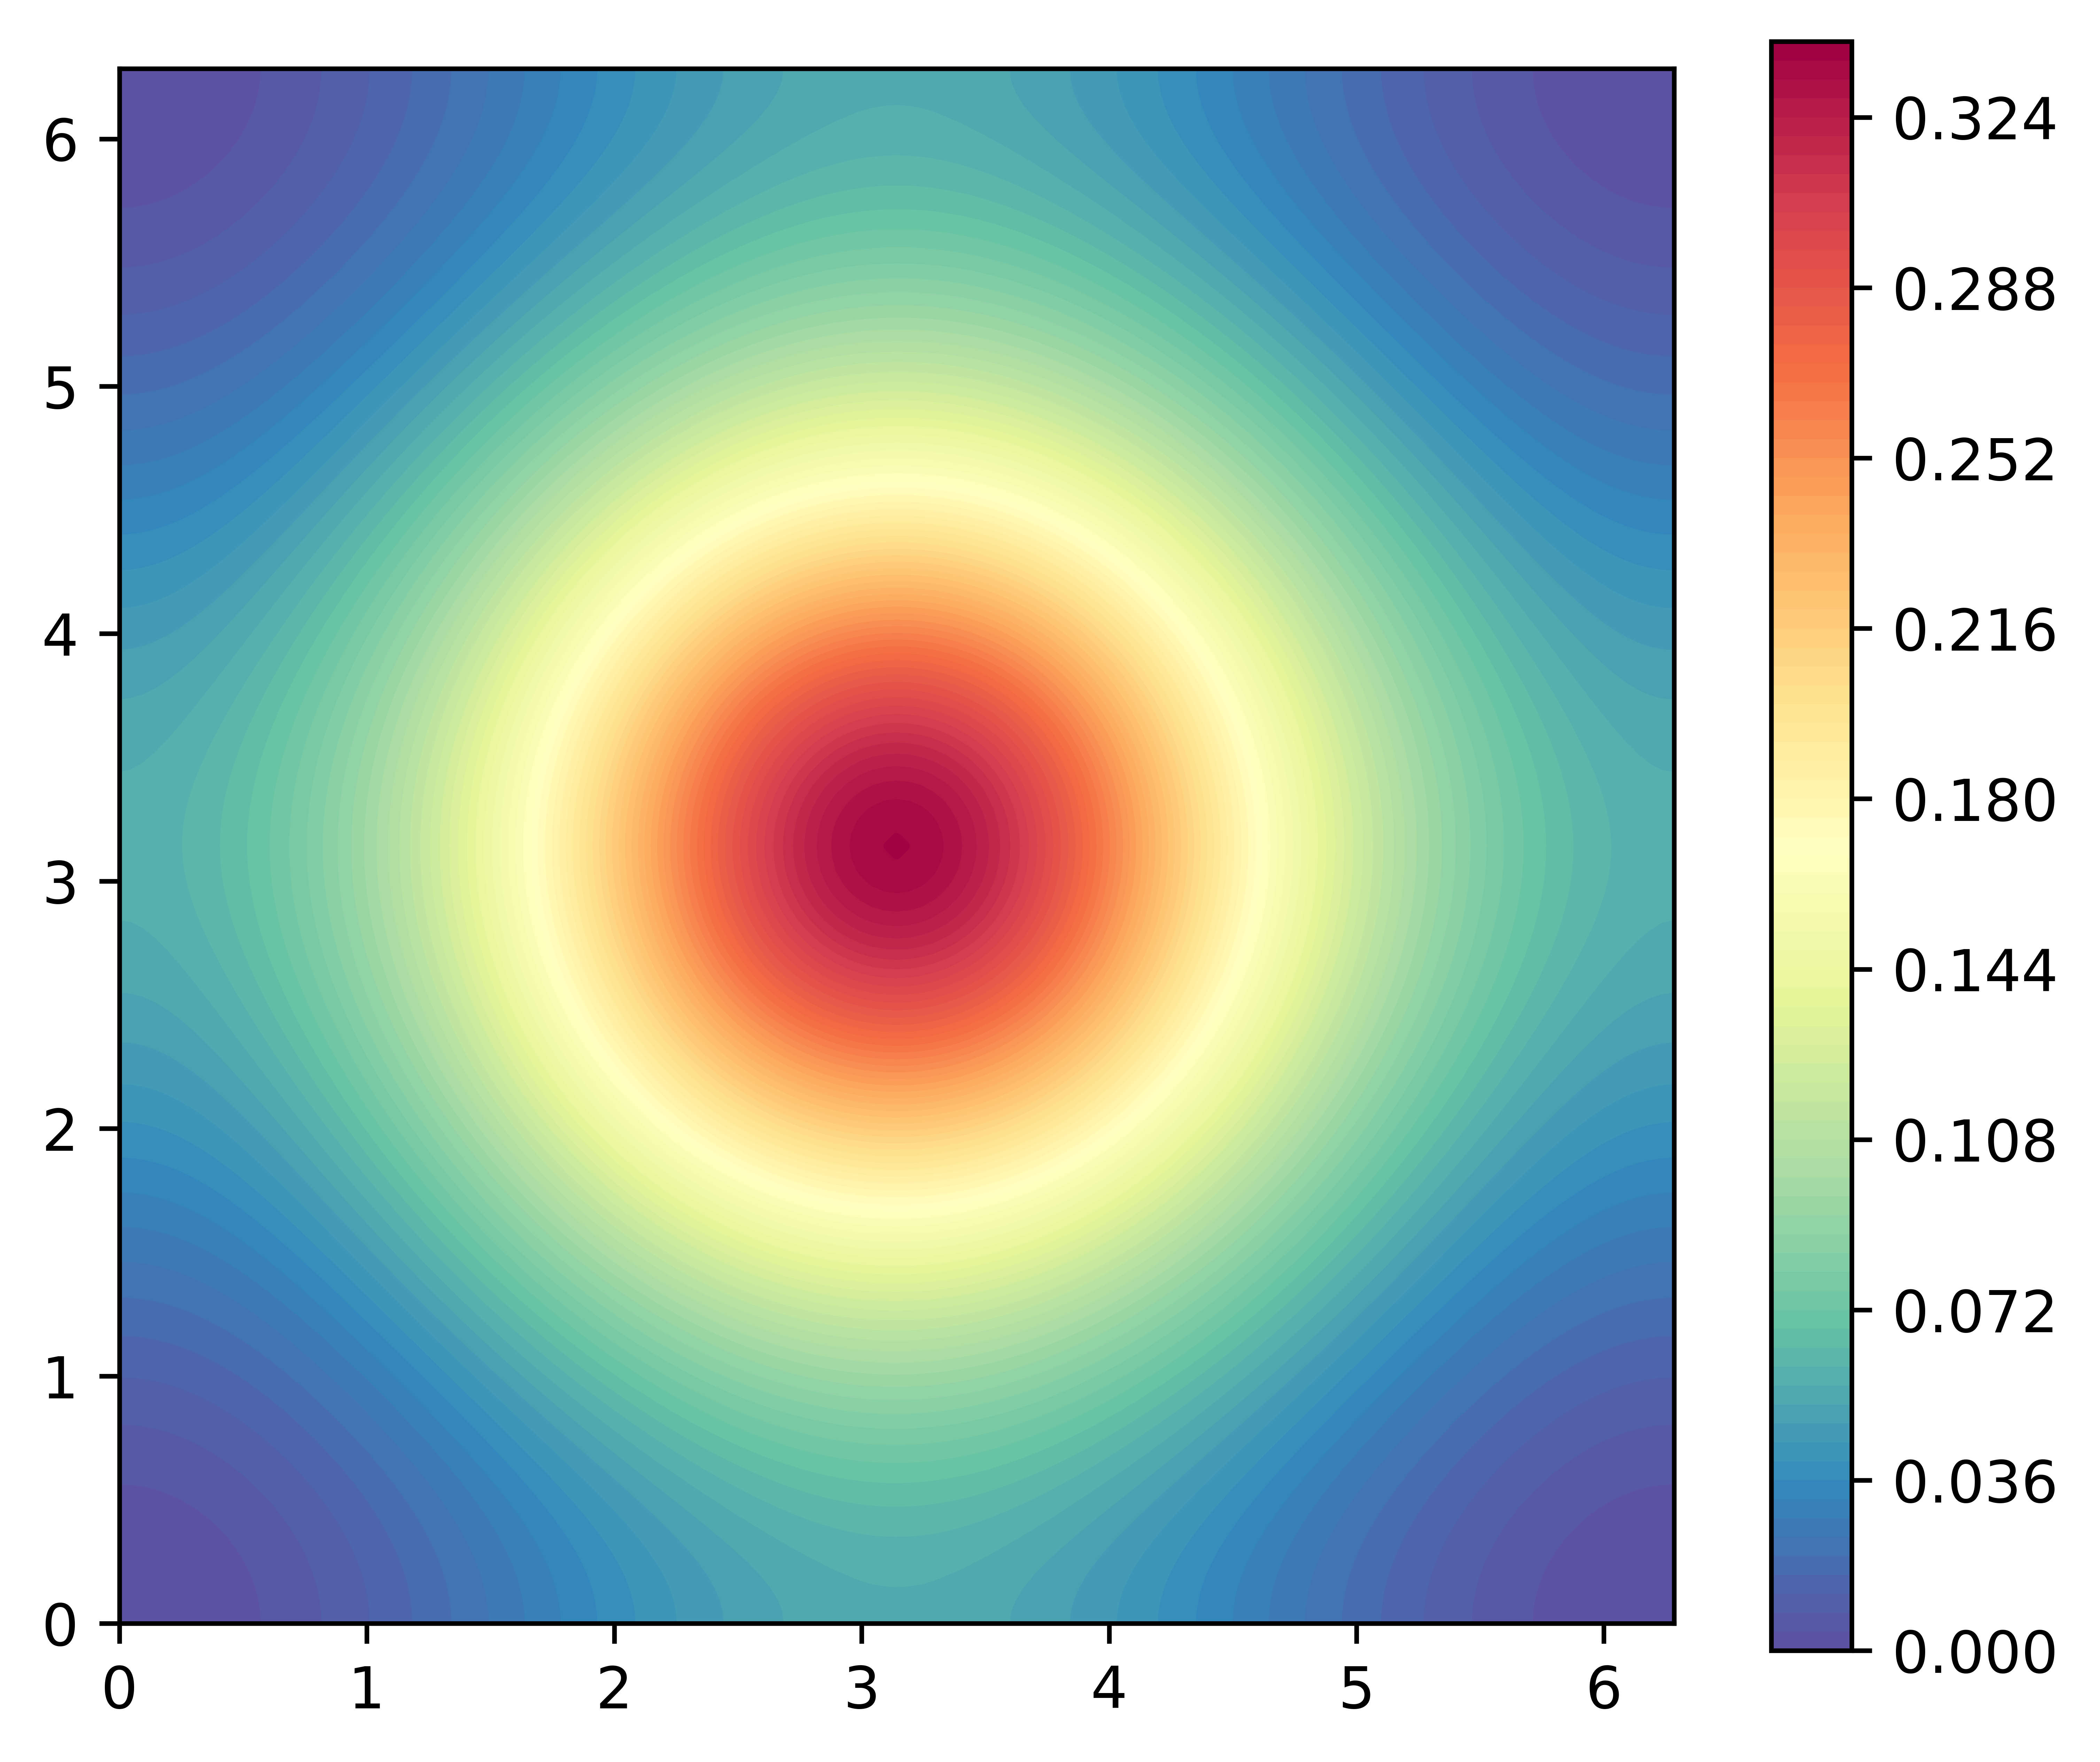

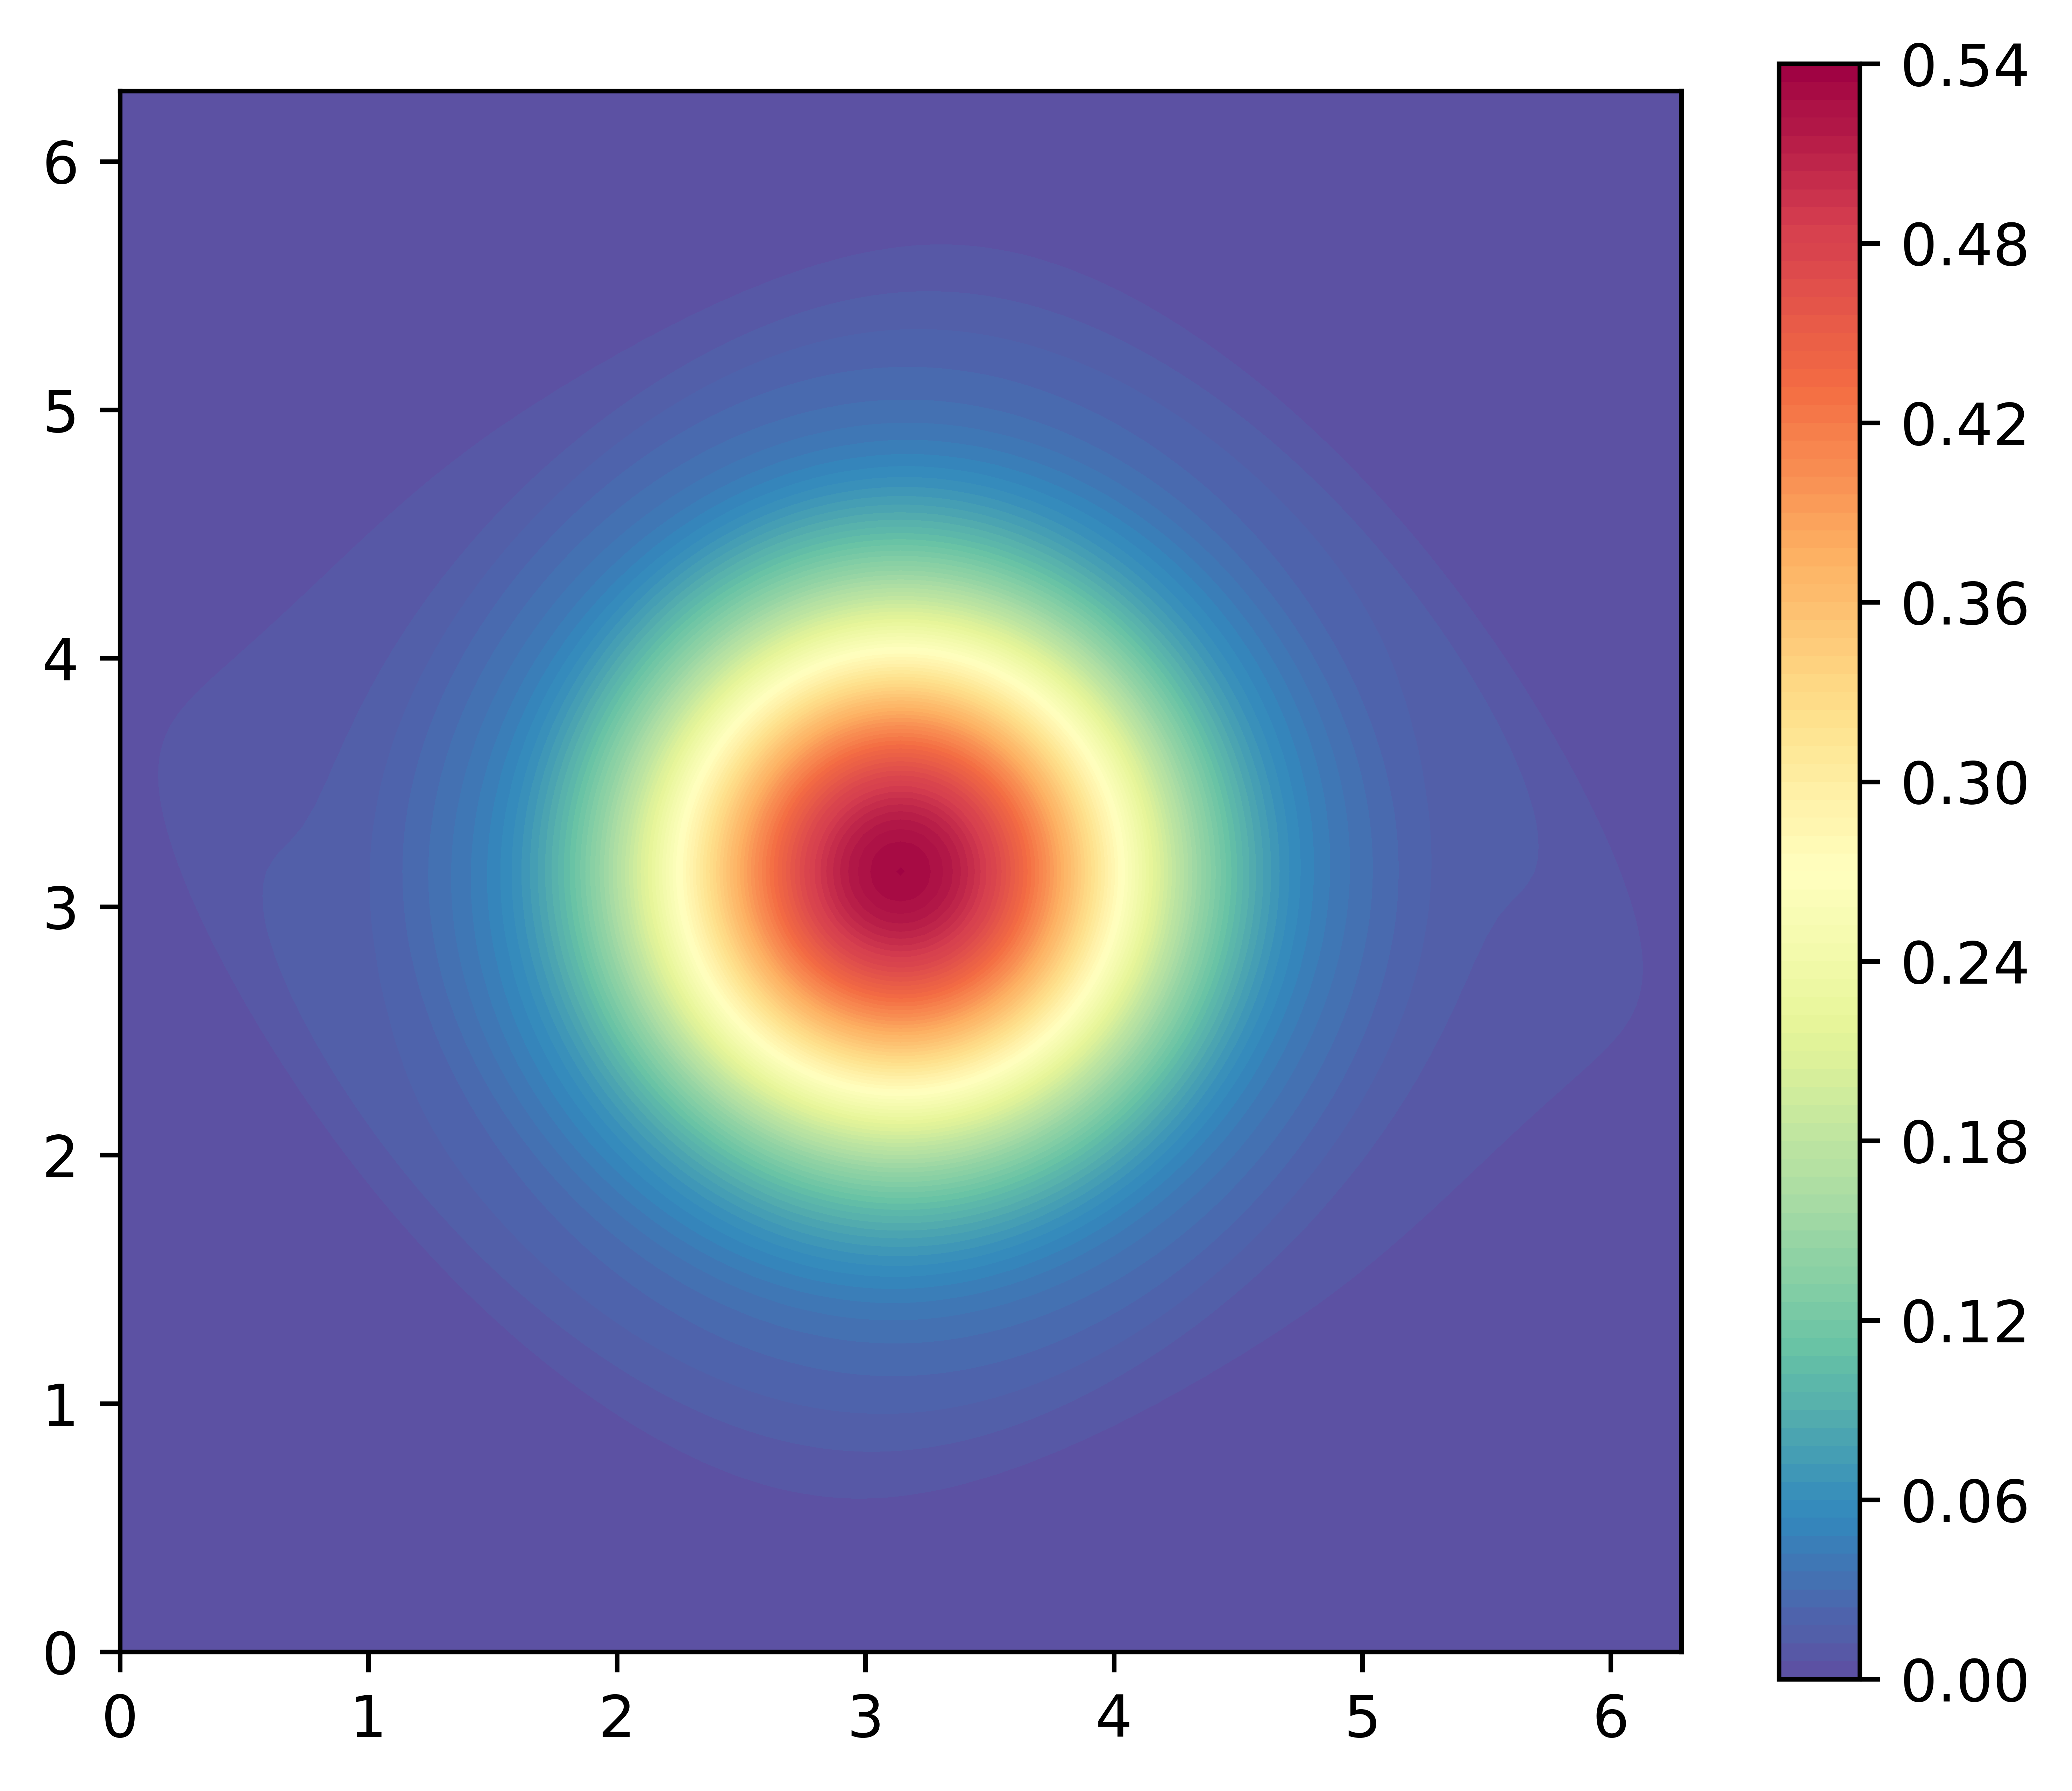

In [202]:
colormap = matplotlib.colormaps["Spectral_r"]

fig, ax = plt.subplots(figsize=(6, 5))
a = ax.contourf(xMat, yMat, sOriginal, levels=100, cmap=colormap)
ax.set_xlim([0, 2*np.pi])
ax.set_ylim([0, 2*np.pi])
ax.set_aspect("equal")
cbar = fig.colorbar(a)

fig, ax = plt.subplots(figsize=(6, 5))
a = ax.contourf(xMat, yMat, wOriginal, levels=100, cmap=colormap)
ax.set_xlim([0, 2*np.pi])
ax.set_ylim([0, 2*np.pi])
ax.set_aspect("equal")
cbar = fig.colorbar(a)
